# 手撕经典算法YOLOv3


# 一、理论部分

## 1、特征提取网络

1）全卷积网络，无pooling层，对输入尺寸不固定

2）网络下采样的stride参数，用来表示被下采样的倍数，例如stride=32，输入尺寸/输出特征尺寸==32

## 2、Output
1）使用1\*1卷积来生成输出

2）输出的feature map中的一个单元的长度是(B x (5 + C)) ，B代表每个cell预定义个anchor，5代表YOLO经典的坐标+目标分数，C代表类别数

一个感性的理解：

若原始图片中的目标的中心位置，存在于某个输出特征的cell的感受野中，这个目标就应该是该cell预测出来的

因此，首先要做的是：将输入图片划分为等于输出特征数量的grid 

假设输入图片是416\*416，网络的stride是32，那么输出特征尺寸是416/32=13

因此将输入图片划分为13\*13的grid，如下图
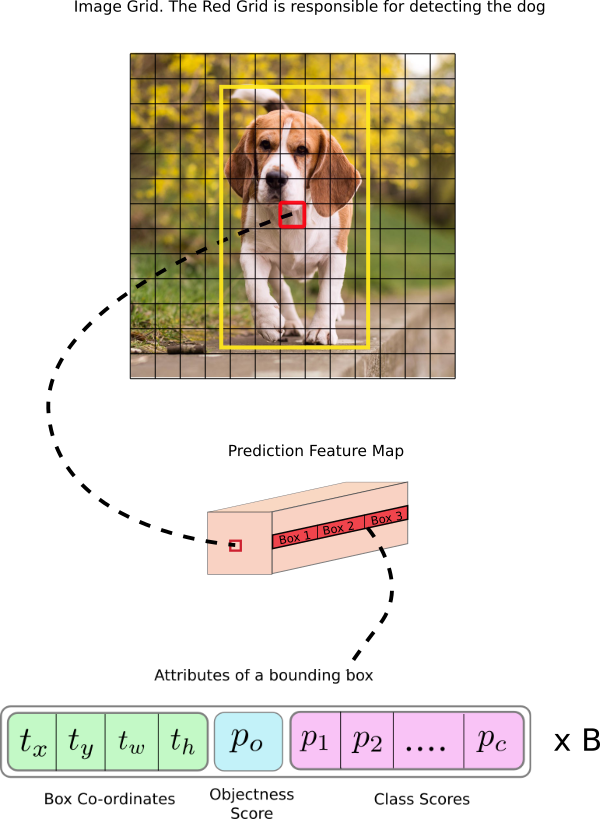

其中，红色的就是目标的中心位置，处于grid的第7行，第7列

那在Feature Map中的位置也是第7行第7列，包含3个box，每个box展开都是(B x (5 + C))个元素


### 2.1 Anchor Boxes
1）YOLOv3的每个预测单元有3个anchor，对应着3个bbox

2）确定哪一个bbox是以及其anchor对应正样本的规则是：取所有的bbox中，与gtIOU最大的那个

### 2.2 Making Predictions

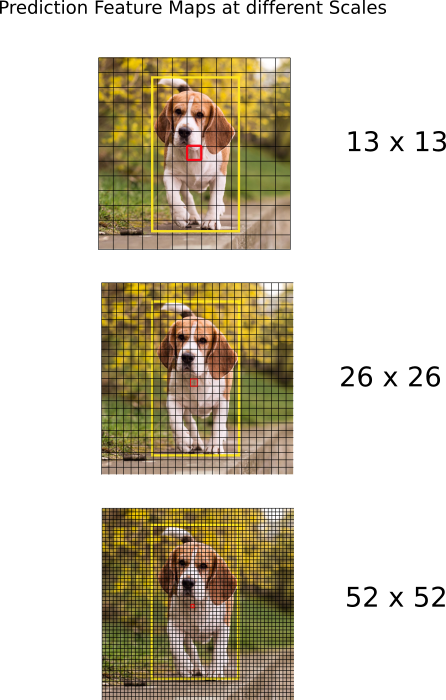

bx, by, bw, bh就是最终的预测的坐标值

tx, ty, tw, th是网络的输出

cx, cy是anchor的中心/也是该gridcell的左上角距离图片左上角的距离

pw, ph是anchor的宽高

#### 其中的一些细节：

1）使用sigmoid函数sigmoid(tx)、sigmoid(ty)的原因：使用基于gridcell尺寸的归一化，对训练相对更稳定

例如：在13\*13的输出特征中，假设sigmoid(tx)、sigmoid(ty) = (0.4, 0.7)、在第6个cell中，那么该box的中心坐标为:

- bx = 6.4
- by = 6.7

2) tw、th应用了log函数，然后乘以anchor的宽高pw, ph(归一化后)，因此假设：bw, bh = (0.3, 0.8)，则
- 实际w = 0.3\*13
- 实际h = 0.8\*13

3) Objectness Score：原文中作者说该值为0/1的离散值，但是具体caffe实现中，把其计算方式改为sigmoid的离散值

4) Class Confidences：
- YOLOv3之前，作者使用的softmax做类别预测
- v3作者改为sigmoid代替，原因是方便支持多类以及重叠目标

5）多尺度预测
- 使用了3种尺度预测，stride分别为： 32, 16, 8，也就是说当输入尺寸为416时，输出的多尺度 特征尺寸分别为: 13\*13 26\*26 52\*52
- 每种尺度的特征使用upsampling 操作，并与前一尺寸的特征进行concate操作，生成下一尺度的预测特征

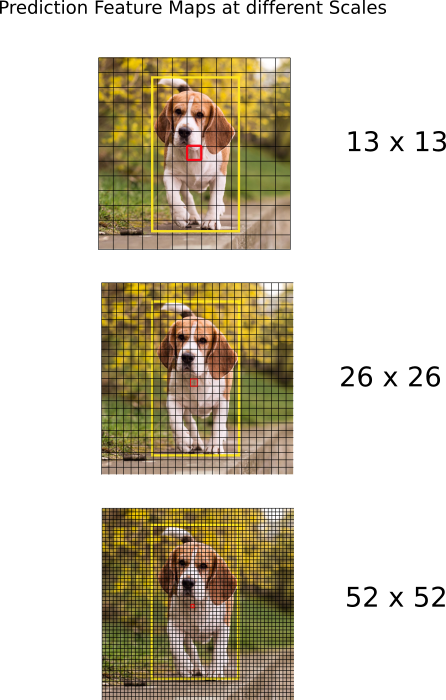

6）Output Processing
对于每个416\*416的图片，网络预测的bbox数量为:((52×52)+(26×26)+(13×13))×3=10647个，然而实际图片中的目标数量很少，接下来就是如何减少冗余预测的方法
- Objectness score: 首先，使用过滤objectness score < 阈值的bbox
- NMS过滤同一对象的预测


# 二、实现部分

1、配置文件：官方代码使用配置文件来搭建网络，这里我们采用相同的形式

首先，下载官方提供的cfg文件，然后将其放入到cfg文件夹中

In [1]:
! mkdir cfg
! cd cfg
! wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

mkdir: cannot create directory ‘cfg’: File exists
--2020-12-29 06:37:03--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.228.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.228.133|:443... failed: Connection refused.


In [5]:
# 看一下cfg
! cat ./cfg/yolov3.cfg

[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=64
subdivisions=16
width=608
height=608
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutiona

在YOLOv3中，总共有5中类型的层，分别如下

#### route的作用：

当他有1个值时，意思是输出该值的索引的特征层特征

当他的值为2个时，输出这两个索引的特征的concate

## 接下来的代码请见仓库